#Resumo

- O desafio proposto trata sobre o transtorno depressivo, um problema multifatorial que pode ter várias possíveis combinações de situações como causa.

- Os dados disponíveis são resultados da NHNES (National Health and Nutrition Examination Survey), realizada anualmente nos EUA para avaliar a saúde e nutrição de adultos e crianças;

- Seu desafio é responder as seguintes perguntas:

  - Qual o perfil de indivíduos (adultos maiores de 18 anos) com sintomas depressivos nos EUA no período de 2005-2006?

  - Hábitos saudáveis de alimentação e atividade física estão associados a menores índices de depressão nesta população?



In [93]:
import pandas as pd
import numpy as np

demo_phq = pd.read_csv('/content/DEMO_PHQ.csv')
pag_hei = pd.read_csv('/content/PAG_HEI.csv')

demo_phq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5334 non-null   int64  
 1   DPQ010    4836 non-null   float64
 2   DPQ020    4836 non-null   float64
 3   DPQ030    4836 non-null   float64
 4   DPQ040    4836 non-null   float64
 5   DPQ050    4836 non-null   float64
 6   DPQ060    4836 non-null   float64
 7   DPQ070    4836 non-null   float64
 8   DPQ080    4836 non-null   float64
 9   DPQ090    4836 non-null   float64
 10  RIAGENDR  5334 non-null   int64  
 11  RIDAGEYR  5334 non-null   int64  
 12  RIDRETH1  5334 non-null   int64  
 13  DMDEDUC   5334 non-null   int64  
 14  INDFMINC  5287 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 625.2 KB


In [94]:
pag_hei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SEQN                      9424 non-null   int64  
 1   PAG_MINW                  7150 non-null   float64
 2   ADHERENCE                 7150 non-null   float64
 3   HEI2015C1_TOTALVEG        8549 non-null   float64
 4   HEI2015C2_GREEN_AND_BEAN  8549 non-null   float64
 5   HEI2015C3_TOTALFRUIT      8549 non-null   float64
 6   HEI2015C4_WHOLEFRUIT      8549 non-null   float64
 7   HEI2015C5_WHOLEGRAIN      8549 non-null   float64
 8   HEI2015C6_TOTALDAIRY      8549 non-null   float64
 9   HEI2015C7_TOTPROT         8549 non-null   float64
 10  HEI2015C8_SEAPLANT_PROT   8549 non-null   float64
 11  HEI2015C9_FATTYACID       8549 non-null   float64
 12  HEI2015C10_SODIUM         8549 non-null   float64
 13  HEI2015C11_REFINEDGRAIN   8549 non-null   float64
 14  HEI2015C

###realizando o tratamento das categorias 7 = “Se recusou a responder” e 9 = “Não sabe”.


In [95]:
#vendo a distribuição de valores nesta variavel 
demo_phq['INDFMINC'].value_counts()

11.0    1044
6.0      678
7.0      535
8.0      485
3.0      440
5.0      426
4.0      412
9.0      297
2.0      281
10.0     278
1.0      190
12.0      78
99.0      77
77.0      36
13.0      30
Name: INDFMINC, dtype: int64

In [96]:
#como irei utilizar replace vou reservar uma das variaveis onde os valores não batem com a alteração 
reserv = demo_phq['INDFMINC']
demo_phq.drop(['INDFMINC'], axis = 1, inplace = True)
#transformando os valores 7 e 9 que indicam que a pessoa nao quis responder ou nao sabia para nulos
demo_phq = demo_phq.replace(7.0, np.nan)
demo_phq = demo_phq.replace(9.0,np.nan)
#transformando os valores 77 e 99 da variavel reservada que tbm indicam que a pessoa nao quis responder ou nao sabia
reserv = reserv.replace (77, np.nan)
reserv = reserv.replace (99, np.nan)



In [97]:
#juntando a variavel reservada novamente com o dataset 
demo_phq = demo_phq.join(reserv,how = 'inner')


###Combinando os dois bancos e lidando com os dados faltantes

In [98]:
#juntando os dois datasets o de questionario de depressão e o questionario de habitos
#usei um innerJoin pois como o demo_phq so possui adultos é uma maneira de só puxar os adultos do pag_hei e excluir as crianças
df = demo_phq.set_index('SEQN').join(pag_hei.set_index('SEQN'), how='inner')

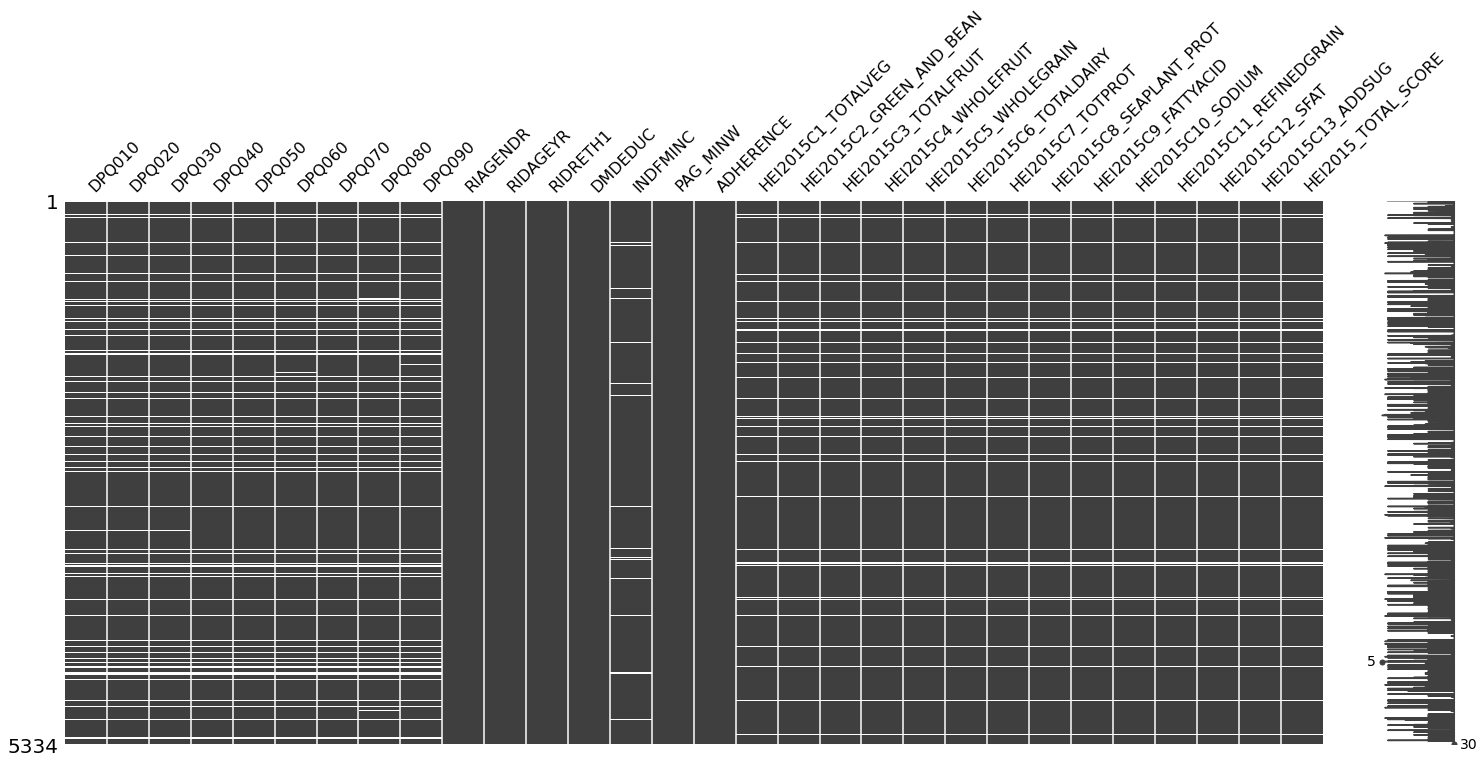

In [99]:
#visualizando os dados faltantes 
import missingno as msno
msno.matrix(df)

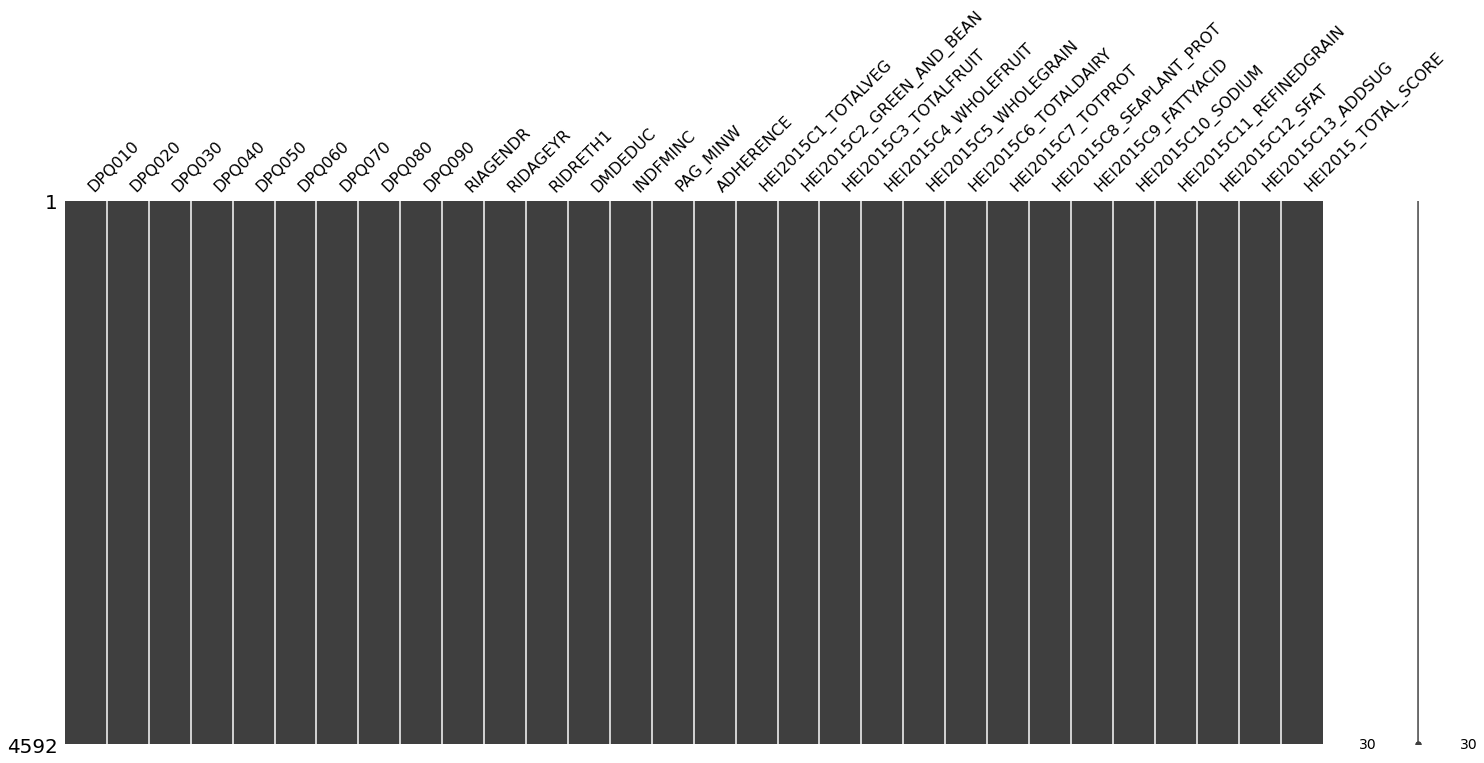

In [100]:
#apesar de possuirmos colunas onde os dados estão integros elas não representam as nossas variaveis de Maior interesse (questionario)
#ou seja os dados faltantes são em sua totalidade perguntas do questionario, onde um entrevistado aparentemente não respondeu nenhuma pergunta
#então optei por excluir todas essas linhas que possuem dados faltantes 
df = df.dropna()
msno.matrix(df)

### Criando a variavel phq9 (score)
o score é a soma de todo questionario

In [101]:
#somando todo o questionario para ter a variavel de score 
df['phq9'] = df['DPQ010']+ df['DPQ020']+df['DPQ030']+ df['DPQ040'] +df['DPQ050']+df['DPQ060']+df['DPQ070']+df['DPQ080']+df['DPQ090']

### criar variavel phq_grp com a classificação do escore phq9

- 0 (sem sintoma)
- 1 (sintomas leves)
- 2 (sintomas moderados)
- 3 (sintomas moderadamente severos)
- 4 (sintomas severos)

In [102]:
#criando uma função e definindo as condições que desejo para a nova variavel 
def classificar(x):
  if x <5:
    return 0
  elif (x >= 5) & (x <10):
    return 1
  elif (x >=10) & (x <15):
    return 2 
  elif (x >=15) & (x <19):
    return 3
  elif x >= 20:
    return 4

#criando a nova variavel(coluna) e chamando a função criada com apply
df['phq_grp'] = df['phq9'].apply(classificar)

In [103]:
#verificando como ficou a classificação 
df['phq_grp'].value_counts()

0.0    3654
1.0     655
2.0     191
3.0      59
4.0      22
Name: phq_grp, dtype: int64

# ANÁLISE EXPLORATÓRIA (EDA) UNIVARIADA

## Identificando os tipos das Variaveis 

###Variaveis quantitativas 
```
RIDAGEYR
PAG_MINW
HEI2015C1_TOTALVEG 
HEI2015C2_GREEN_AND_BEAN
HEI2015C3_TOTALFRUIT 
HEI2015C4_WHOLEFRUIT
HEI2015C5_WHOLEGRAIN 
HEI2015C6_TOTALDAIRY
HEI2015C7_TOTPROT
HEI2015C8_SEAPLANT_PROT 
HEI2015C9_FATTYACID 
HEI2015C10_SODIUM
HEI2015C11_REFINEDGRAIN 
HEI2015C12_SFAT
HEI2015C13_ADDSUG
HEI2015_TOTAL_SCORE 
phq9
```
### Variaveis qualitativas 
```
RIAGENDR
RIDRETH1 
DMDEDUC 
INDFMINC
phq_grp
```


In [104]:
#modificando variaveis para uma visualização mais conveniente
genderMap = {1: 'Masculino',
            2: 'Feminino'}

racaMap = {1: 'Branco', 
           2: 'negro',
           3: 'Mexicano-Americano',
           4: 'Outro',
           5: 'Outro'}


escolaMap = {1: 'Menor que o 9 ano',
             2: 'do 9 ao 12 ano',
             3: 'Ensino Medio',
             4: 'Ensino superior Incompleto',
             5: 'Superior completo ou maior'}

aderenMap = {1: 'Baixo',
             2: 'Adequado',
             3: 'Acima'}

phqMap = {0: 'sem sintoma',
          1: 'sintomas leves',
          2: 'sintomas moderados',
          3: 'sintomas moderadamente severo',
          4: 'Sintoma severo'}


df['RIAGENDR']= df['RIAGENDR'].map(genderMap)
df['RIDRETH1'] = df['RIDRETH1'].map(racaMap)
df['DMDEDUC']= df['DMDEDUC'].map(escolaMap)
df['ADHERENCE']= df['ADHERENCE'].map(aderenMap)
df['phq_grp']= df['phq_grp'].map(phqMap)



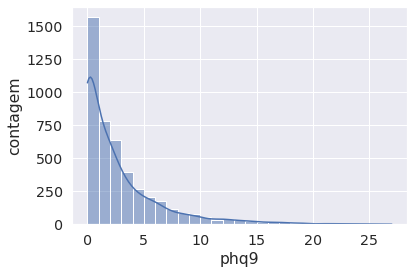

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.3)

sns.histplot(df['phq9'],
             binwidth=1,
             kde=True,
            
            ) 
plt.ylabel('contagem')
plt.show()

podemos ver que a maioria das pessoas tem um score proximo de 0 ou seja não possuem sintomas de depressão 


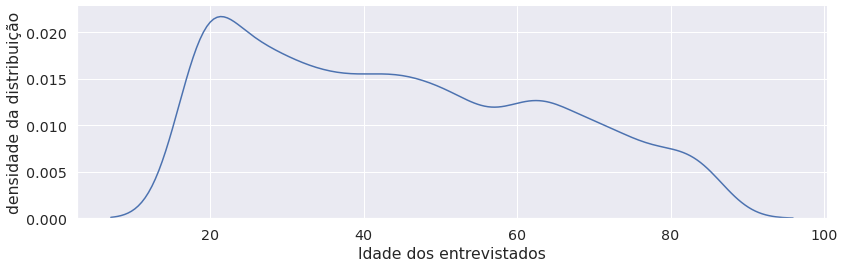

In [117]:
sns.displot(df['RIDAGEYR'],
            height = 4,
            aspect = 3,
            kind = 'kde') #distribuição continua 
plt.ylabel('densidade da distribuição')
plt.xlabel('Idade dos entrevistados')
plt.show()

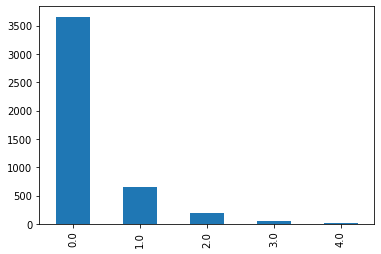

In [90]:
df["phq_grp"].value_counts().plot(kind = 'bar')

Visualizando o nivel de sintomas pela variavel de classificação 


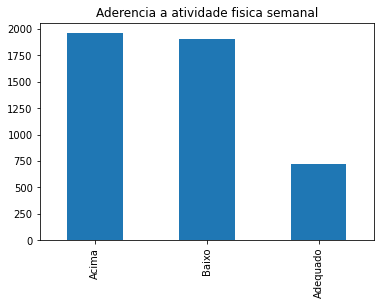

In [107]:
df["ADHERENCE"].value_counts().plot(kind = 'bar', title = 'Aderencia a atividade fisica semanal')

verificando a pratica por semana de atividade fisica 
- Baixo (< 150min/semana)
- Adequado(150-300 min/semana)
- Acima (> 300min/semana

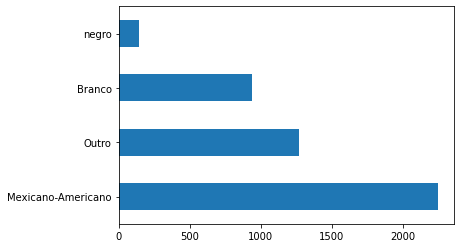

In [108]:
df["RIDRETH1"].value_counts().plot(kind = 'barh')

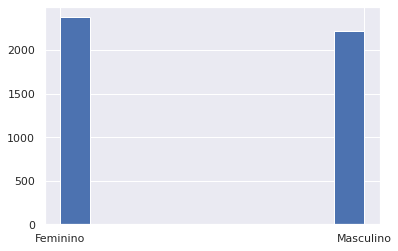

In [ ]:
df['RIAGENDR'].hist()

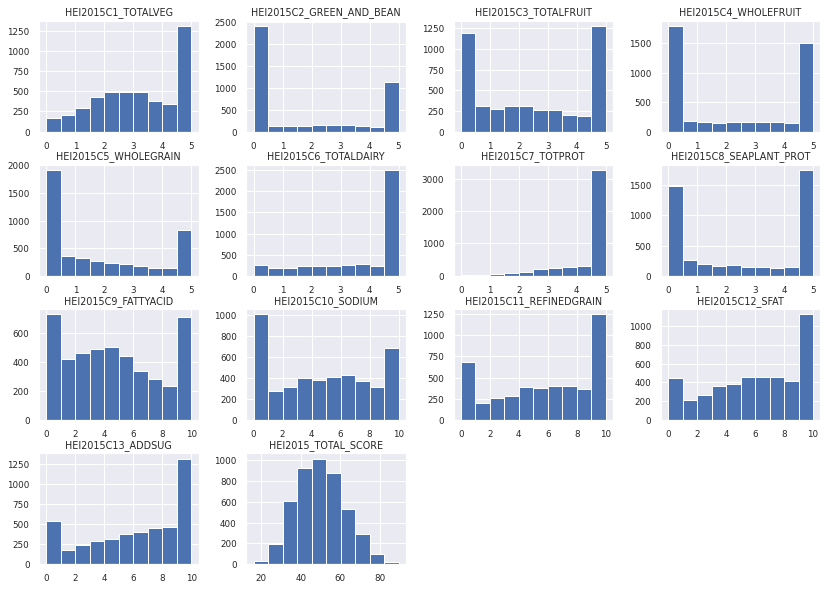

In [123]:
listaquest = ['HEI2015C1_TOTALVEG', 
                'HEI2015C2_GREEN_AND_BEAN',
                'HEI2015C3_TOTALFRUIT' ,
                'HEI2015C4_WHOLEFRUIT',
                'HEI2015C5_WHOLEGRAIN' ,
                'HEI2015C6_TOTALDAIRY',
                'HEI2015C7_TOTPROT',
                'HEI2015C8_SEAPLANT_PROT', 
                'HEI2015C9_FATTYACID', 
                'HEI2015C10_SODIUM',
                'HEI2015C11_REFINEDGRAIN', 
                'HEI2015C12_SFAT',
                'HEI2015C13_ADDSUG',
                'HEI2015_TOTAL_SCORE']

sns.set(font_scale = 0.8)
df[listaquest].hist(figsize = (14, 10));

#### Dicionario


- HEI2015C1_TOTALVEG - Total de Vegetais
- HEI2015C2_GREEN_AND_BEAN - Verduras verde escuras e leguminosas
- HEI2015C3_TOTALFRUIT - Frutas totais
- HEI2015C4_WHOLEFRUIT - Frutas in natura 
-HEI2015C5_WHOLEGRAIN - Grãos integrais 
- HEI2015C6_TOTALDAIRY- Laticínios 
- HEI2015C7_TOTPROT - Proteínas
- HEI2015C8_SEAPLANT_PROT - Plantas marinhas e proteínas vegetais
- HEI2015C9_FATTYACID - Ácido-graxo
- HEI2015C10_SODIUM Healthy - Sódio 
- HEI2015C11_REFINEDGRAIN - Grãos refinados
- HEI2015C12_SFAT - Gordura saturada
- HEI2015C13_ADDSUG - Açúcares adicionados
- HEI2015_TOTAL_SCORE - Escore total 

# ANÁLISE EXPLORATÓRIA (EDA) BIVARIADA






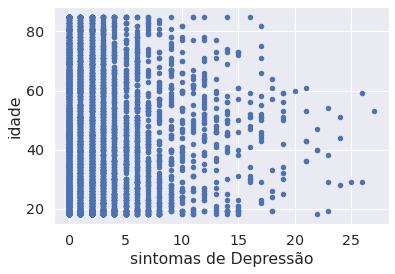

In [149]:
df.plot(x = 'phq9', y ='RIDAGEYR', kind = 'scatter')
plt.ylabel('idade')
plt.xlabel('sintomas de Depressão')
plt.show()

Nesta pesquisa são quase inexistentes sintomas severos de depressão para pessoas acima de 60 anos 

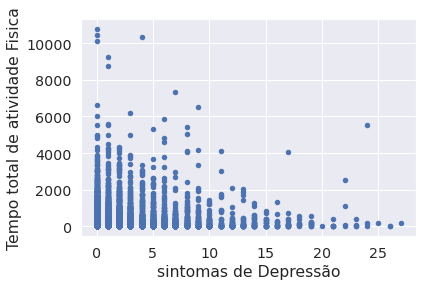

In [151]:
df.plot(x = 'phq9', y ='PAG_MINW', kind = 'scatter')
plt.ylabel('Tempo total de atividade Fisica')
plt.xlabel('sintomas de Depressão')
plt.show()

tempo total de atividade fisica Aerobica por semana 
- Aparentmente pessoas que praticam menos atividades fisicas apresentam sintomas mais severos de depressão 

In [195]:
#criando uma matriz para visualizar todas as variaveis de uma so vez
listaquest = [['HEI2015C1_TOTALVEG', 'HEI2015C2_GREEN_AND_BEAN'],
              ['HEI2015C3_TOTALFRUIT' ,'HEI2015C4_WHOLEFRUIT',],
              ['HEI2015C5_WHOLEGRAIN' ,'HEI2015C6_TOTALDAIRY'],
              ['HEI2015C7_TOTPROT','HEI2015C8_SEAPLANT_PROT'], 
              ['HEI2015C9_FATTYACID','HEI2015C10_SODIUM'],
              ['HEI2015C11_REFINEDGRAIN', 'HEI2015C12_SFAT',],
              ['HEI2015C13_ADDSUG','HEI2015_TOTAL_SCORE']]

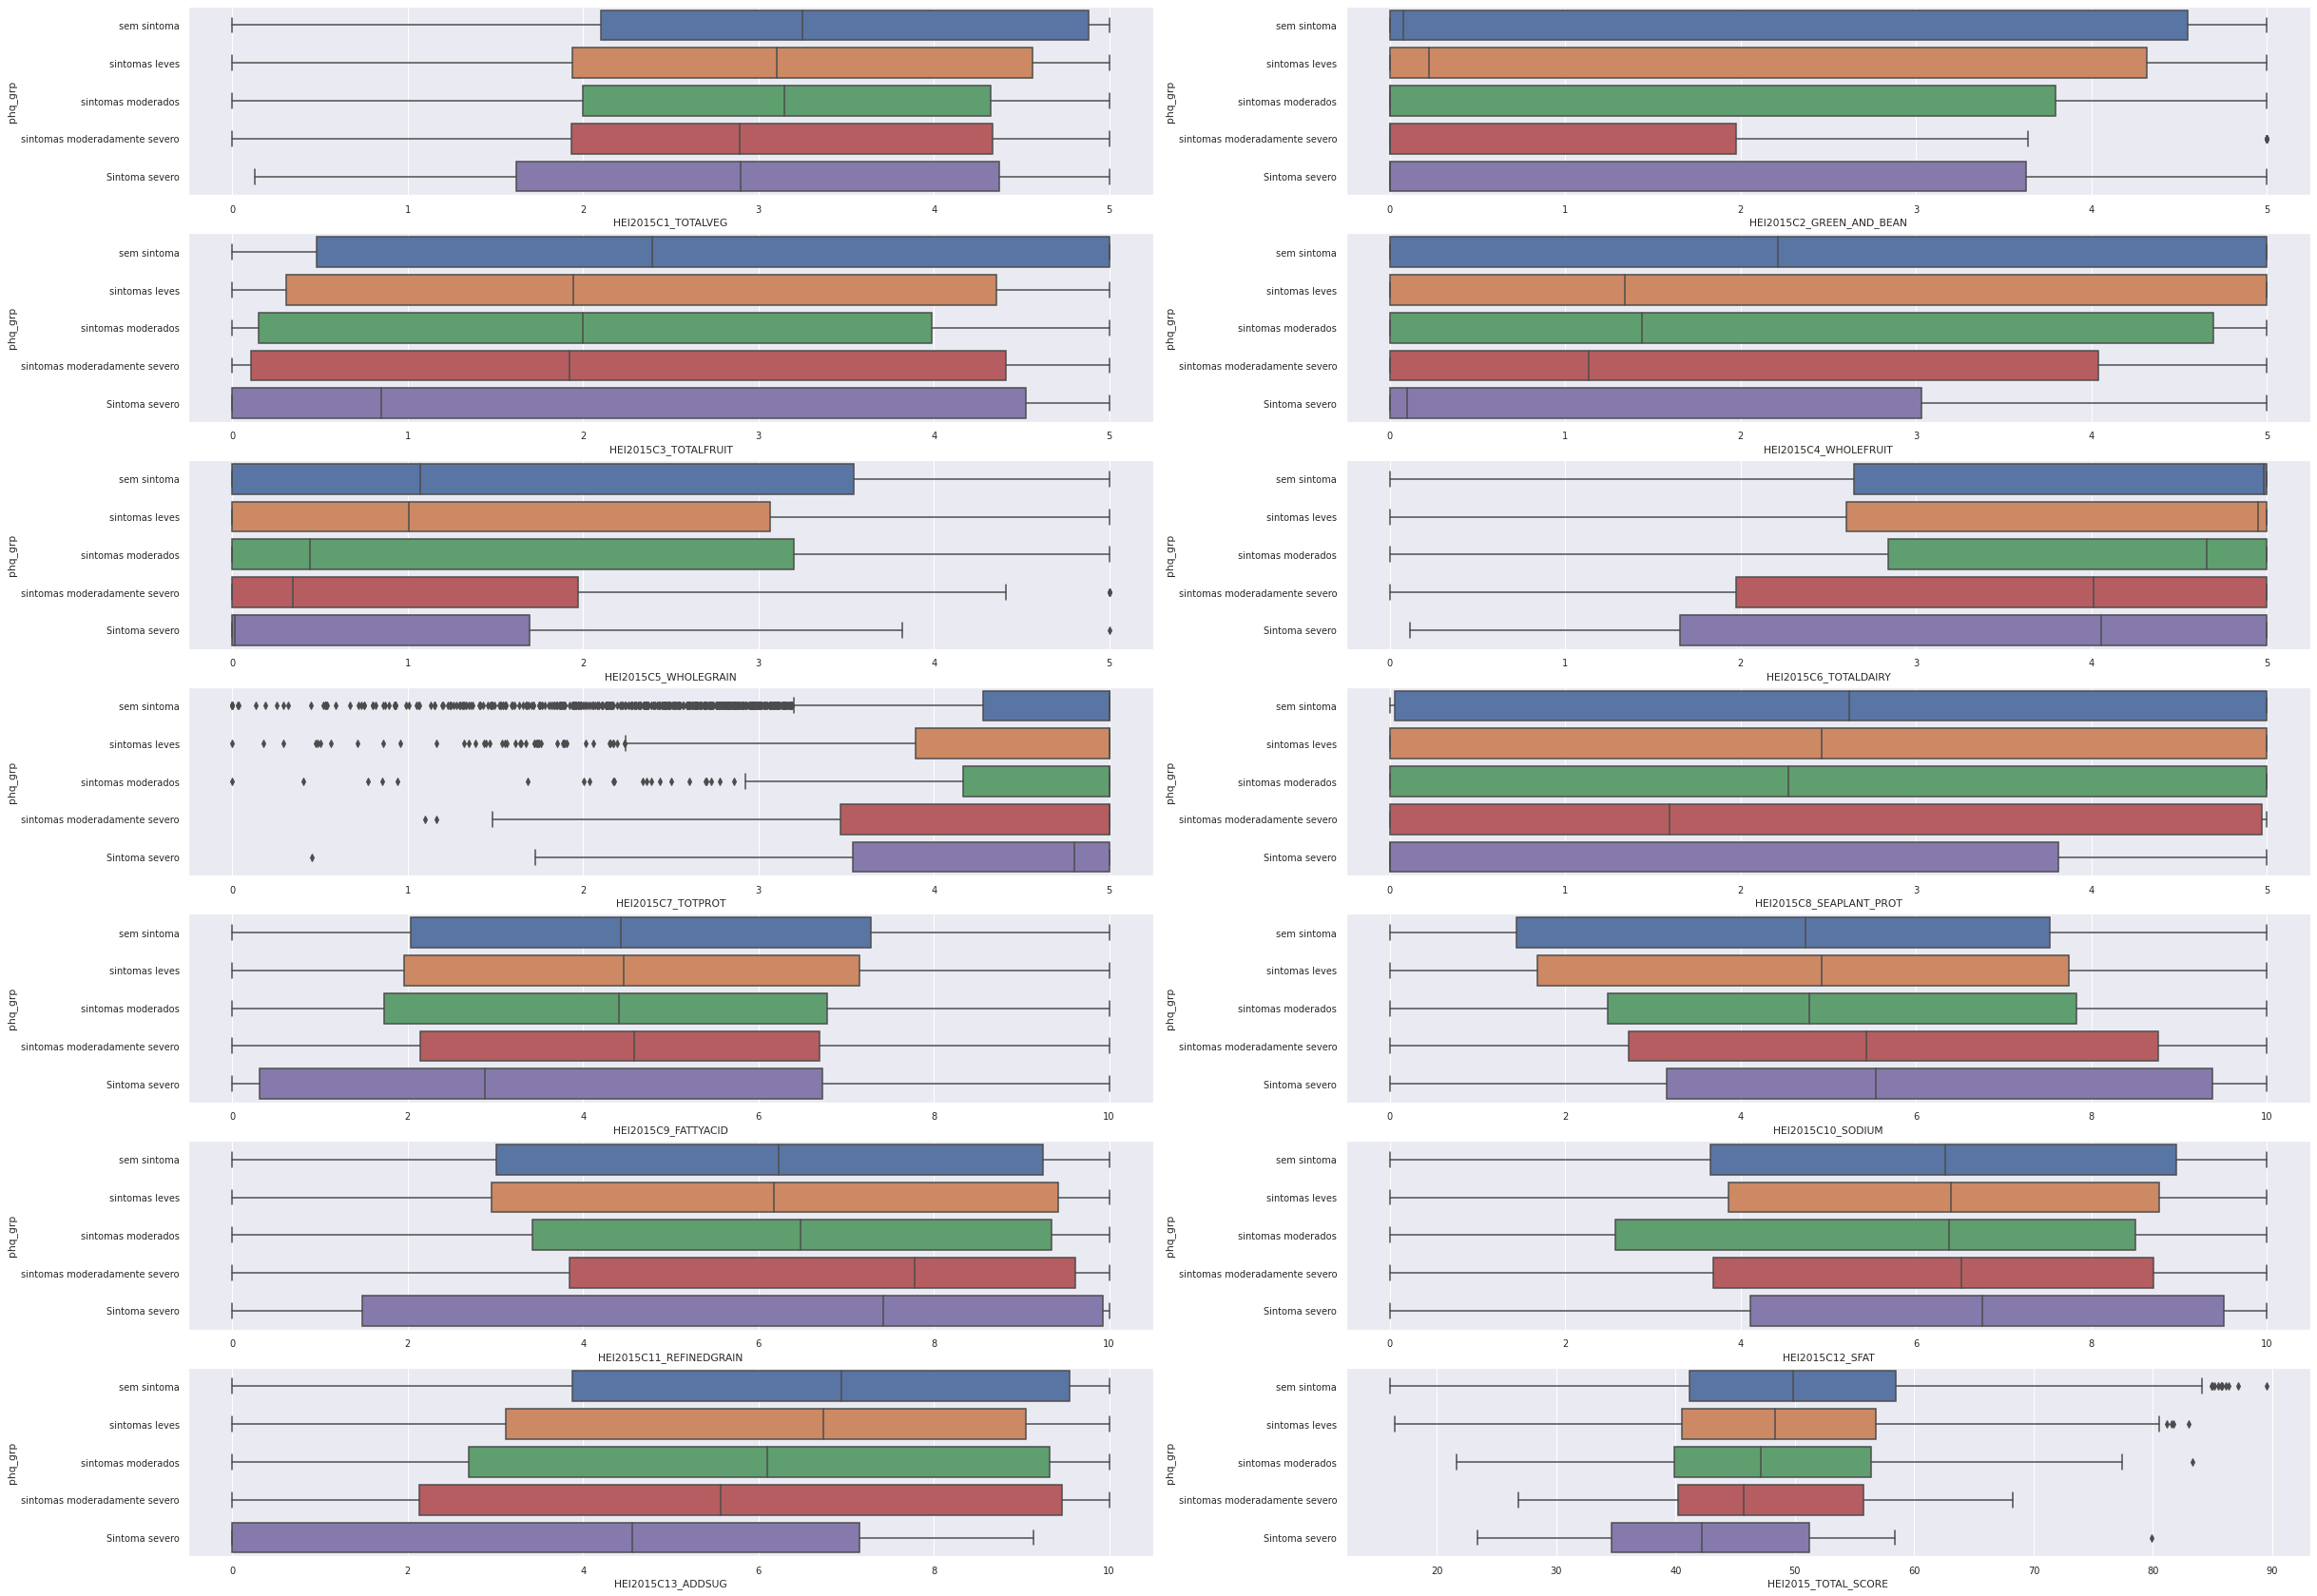

In [210]:
sns.set(font_scale=0.9)
fig, eixo = plt.subplots(7,2,figsize=(40,30)) # Criando uma matriz de 7 linhas x 2 colunas
# Para cada linha 
for linha in range(7):
    # Para cada coluna
    for coluna in range(2): 
      sns.boxplot(data=df,x=listaquest[linha][coluna],y='phq_grp',ax=eixo[linha][coluna],orient='h')

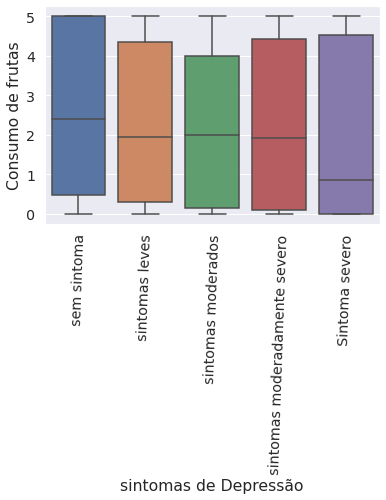

In [179]:
#visualizando a correlação da variavel Numero total de frutas consumidas com sintomas de depressão 
sns.boxplot(
    data=df, # Dataframe utilizado
    x='phq_grp', # Variável no eixo x
    y='HEI2015C3_TOTALFRUIT' # Variável no eixo y
)
plt.xlabel('sintomas de Depressão')
plt.ylabel('Consumo de frutas')
plt.xticks(rotation = 88)
plt.show()

podemos ver que existe um menor consumo de frutas conforme os casos são mais severos 

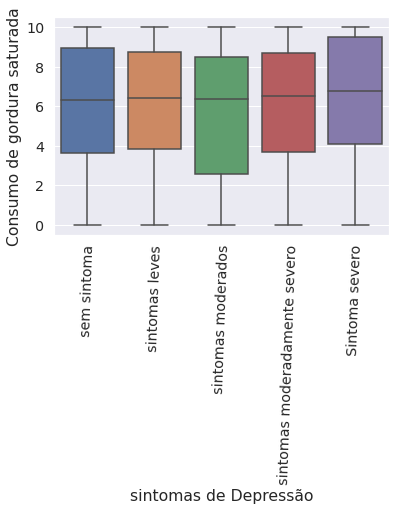

In [178]:
sns.boxplot(
    data=df, # Dataframe utilizado
    x='phq_grp', # Variável no eixo x
    y='HEI2015C12_SFAT'
)
plt.xlabel('sintomas de Depressão')
plt.ylabel('Consumo de gordura saturada')
plt.xticks(rotation = 88)
plt.show()

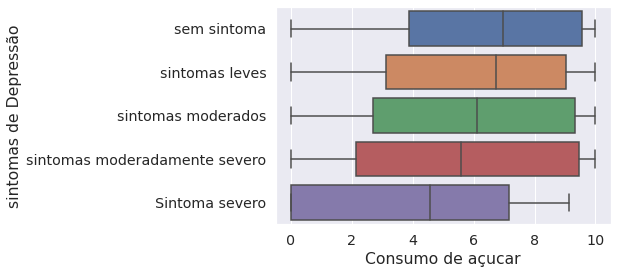

In [177]:
sns.boxplot(
    data=df, # Dataframe utilizado
    x='HEI2015C13_ADDSUG', # Variável no eixo x
    y='phq_grp', # Variável no eixo y
    orient='h'
)
plt.ylabel('sintomas de Depressão')
plt.xlabel('Consumo de açucar')
plt.show()

Pessoas com sintomas severos de depressão consomem menos açucar??
